In [1]:
import numpy as np
import pandas as pd
import volprice as vl
from tqdm import tqdm_notebook
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from itertools import product
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import logging
import inspect

In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')

In [3]:
logging.basicConfig(filename='convergence.tmp.log', level=logging.INFO)
logging.captureWarnings(True)

## Setup the True Parameters /  Simulation Parameters

In [4]:
true_params = {'equity_price': 0.50, 
               'vol_price': -7,
               'phi':-.17,
               'scale': .1,
               'delta': 1.22,
               'rho': .8,
              }
time_dim = 3000

## Setup the linking functions.

In [5]:
total_true_params = true_params.copy()
total_true_params.update(
    {'gamma': vl.gamma(rho=true_params['rho'], c=true_params['scale'], delta=true_params['delta'], 
                       phi=true_params['phi'], pi=true_params['vol_price'], theta=true_params['equity_price']),
     'beta':vl.beta(true_params['rho'], true_params['scale'], true_params['phi'], pi=true_params['vol_price'], 
                    theta=true_params['equity_price']),
     'psi':vl.psi(true_params['rho'], true_params['scale'], true_params['phi'], 
                  theta=true_params['equity_price']), 
     'phi_squared': true_params['phi']**2})

## We start by examining the distributions of simulated data

In [6]:
data = vl.simulate_data(time_dim=time_dim, **true_params)

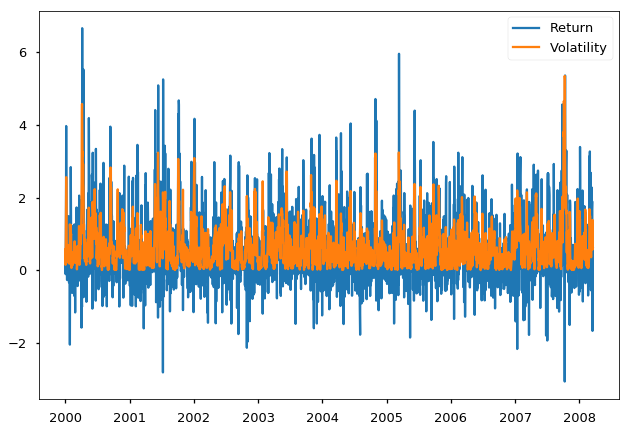

In [7]:
fig1, ax1 = mpl.pyplot.subplots()
ax1.plot(data.rtn, label='Return')
ax1.plot(data.vol, label='Volatility')
ax1.legend()


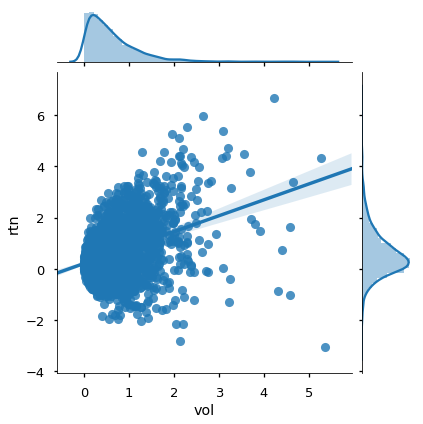

In [8]:
sns.jointplot(x='vol', y='rtn', data=data, kind='reg')

In [9]:
data.describe()

,vol,rtn
count,3000.000000,3000.000000
mean,0.629434,0.596312
std,0.580862,0.939083
min,0.000416,-3.068219
25%,0.222561,0.018576
50%,0.474161,0.442388
75%,0.860850,1.009270
max,5.349333,6.664065


In [10]:
init_constants = vl.compute_init_constants(data.vol)

In [11]:
num_vals = 50
cvals = np.linspace(0, 1,num_vals)
deltavals = np.linspace(0,1.5,num_vals)

In [12]:
plot_data = pd.DataFrame(np.asarray([(scale, intercept, vl.vol_moments(data.vol, .5, scale, intercept).apply(
    np.square).sum().mean())
     for scale, intercept in product(cvals, deltavals)]), columns=['c', 'delta', 'z'])
reshaped_x = plot_data.c.values.reshape((num_vals,num_vals))
reshaped_y = plot_data.delta.values.reshape((num_vals,num_vals))
reshaped_z = plot_data.z.values.reshape((num_vals,num_vals))

Text(0.5,0,'scale')

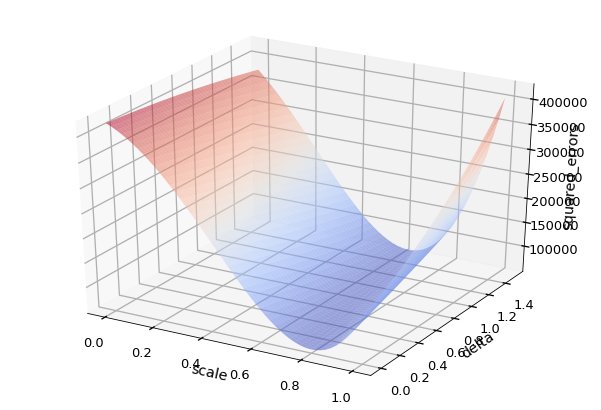

In [27]:
fig = mpl.pyplot.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(reshaped_x, reshaped_y, reshaped_z , cmap=cm.coolwarm, alpha=.5)


ax.set_ylabel('delta')
ax.set_zlabel('squared_errors')
ax.set_xlabel('scale')


In [14]:
params_1st_stage, cov_1st_stage = vl.compute_vol_gmm(data.vol, init_constants=init_constants)

In [15]:
params_1st_stage

{'rho': 0.10296415649260993,
 'scale': 0.85265690643617442,
 'delta': 0.94618775386930487}

In [16]:
reduced_form_est = vl.create_est_table(estimates=params_1st_stage, truth=true_params, cov=cov_1st_stage)

In [17]:
reduced_form_est

,truth,estimate,lower ci,upper ci,in_ci
delta,1.22,0.946188,0.935271,0.957105,False
rho,0.80,0.102964,0.092346,0.113582,False
scale,0.10,0.852657,0.830899,0.874415,False


In [18]:
cov_1st_stage

,rho,scale,delta
rho,0.000029,-0.000034,0.000004
scale,-0.000034,0.000123,-0.000032
delta,0.000004,-0.000032,0.000031


In [19]:
vl.cov_to_corr(cov_1st_stage)

,rho,scale,delta
rho,1.000000,-0.572248,0.136801
scale,-0.572248,1.000000,-0.519630
delta,0.136801,-0.519630,1.000000


# Step 2

In [20]:
step2_est, step2_cov = vl.compute_step2(data)

In [21]:
params_1st_stage.update(step2_est)
cov_stage_1a = cov_1st_stage.copy().merge(step2_cov, left_index=True, right_index=True, how='outer').fillna(0)

In [22]:
vl.create_est_table(estimates=params_1st_stage, truth=total_true_params, cov=cov_stage_1a)


,truth,estimate,lower ci,upper ci,in_ci
beta,1.013063,1.092714,1.021334,1.164094,False
delta,1.220000,0.946188,0.935271,0.957105,False
phi_squared,0.028900,0.064063,-2.511727,2.639852,True
psi,-0.123331,-0.210704,-0.288611,-0.132797,False
rho,0.800000,0.102964,0.092346,0.113582,False
scale,0.100000,0.852657,0.830899,0.874415,False


## I now setup the second-stage derivation

We sometimes get invalid values inside the logarithm for non-optimal values. This would induce a complicated nonlinear constraint for the valid values of the volatilty risk price, but they do not bind, and so we don't bother imposing them.

In [23]:
params_2nd_stage = vl.est_2nd_stage(reduced_form_params=params_1st_stage, reduced_form_cov=cov_stage_1a)

## I now compute the covariance matrix for this 2nd stage regression

I first compute the bread for the sandwich

In [24]:
cov_2nd_stage = vl.compute_2nd_stage_cov(params2=params_2nd_stage, cov1=cov_stage_1a, time_dim=data.shape[0])

In [25]:
vl.create_est_table(estimates=params_2nd_stage, truth=total_true_params, cov=cov_2nd_stage)

,truth,estimate,lower ci,upper ci,in_ci
delta,1.22,5.000000e-01,0.499603,0.500397,False
equity_price,0.50,9.240780e-01,0.923254,0.924902,False
phi,-0.17,3.963529e-15,-0.000199,0.000199,False
rho,0.80,-4.444643e-01,-0.445949,-0.442980,False
scale,0.10,6.984417e-01,0.698442,0.698442,False
vol_price,-7.00,5.739556e-01,0.572616,0.575295,False


In [26]:
vl.cov_to_corr(cov_2nd_stage)

,delta,equity_price,phi,rho,scale,vol_price
delta,1.000000e+00,1.488343e-14,-5.196303e-01,5.016531e-15,-0.037909,0.082793
equity_price,1.265038e-15,1.000000e+00,-1.867121e-15,-5.994922e-01,0.615066,-0.593185
phi,-5.196303e-01,-9.496549e-15,1.000000e+00,-9.041979e-16,0.009076,-0.019792
rho,1.042232e-15,-5.994922e-01,3.260185e-15,1.000000e+00,-1.022112,0.989478
scale,-3.618788e-02,5.828303e-01,8.644436e-03,-9.742734e-01,1.000000,-0.973175
vol_price,8.279309e-02,-5.931846e-01,-1.979245e-02,9.894784e-01,-1.020935,1.000000
